## Plotting of profile results

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database, hyswan_db


In [2]:
from teslakit.database import SplitStorage
def Load_SIM_NEARSHORE_all(db, vns=[], decode_times=False, use_cftime=False, prf=[]):
        ps = db.paths.site.SIMULATION.nearshore

        # locate simulations
        #sims = sorted([x for x in os.listdir(ps) if x.isdigit() and op.isdir(op.join(ps, x))])
        sims = sorted([x for x in os.listdir(ps) if x.endswith("_prf_"+str(prf))])

        # read all simulations
        for c, nm in enumerate(sims):
            ps_sim = op.join(ps, nm)
            s = SplitStorage(ps_sim)

            # read time and variables from first file
            if c==0:
                ds = s.Load(vns=vns, decode_times=False)

                # generate output xarray.Dataset, dims and vars
                out = xr.Dataset({}, coords={'time': ds.time, 'n_sim':range(len(sims))})
                for vds in ds.variables:
                    if vds == 'time': continue
                    out[vds] = (('time', 'n_sim',), np.nan*np.zeros((len(out.time), len(out.n_sim))))
                    out[vds].loc[dict(n_sim=c)] = ds[vds]

            else:
                ds = s.Load(vns=vns, decode_times=False)

                # fill output xarray.Dataset
                for vds in ds.variables:
                    if vds == 'time': continue
                    out[vds].loc[dict(n_sim=c)] = ds[vds]

        # optional decode times to cftime 
        if decode_times:
            out = xr.decode_cf(out, use_cftime=use_cftime)

        return out

In [3]:
# --------------------------------------
# Teslakit database
p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
# p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'
# offshore
db = Database(p_data)
db.SetSite('GUAM')

# climate change - S6
db_S6 = Database(p_data)
db_S6.SetSite('GUAM_CC_S6')

# hyswan simulation database
db_sim = hyswan_db(db.paths.site.HYSWAN.sim)
db_sim_S6 = hyswan_db(db_S6.paths.site.HYSWAN.sim)

### Set profile and load data

In [4]:
prf=11
profiles=xr.open_dataset('/media/administrador/HD/Dropbox/Guam/bati guam/Profiles_Guam_curt.nc')
profile=profiles.sel(profile=prf)
profile


<xarray.Dataset>
Dimensions:             (number_points: 500)
Coordinates:
  * number_points       (number_points) int64 0 1 2 3 4 ... 495 496 497 498 499
    profile             int64 11
Data variables:
    Lon                 (number_points) float64 ...
    Lat                 (number_points) float64 ...
    Elevation           (number_points) float64 ...
    Distance_profile    (number_points) float64 ...
    Rep_coast_distance  int64 ...

In [5]:
def Plot_profile(profile):
    colors=['royalblue','crimson','gold','darkmagenta','darkgreen','darkorange','mediumpurple','coral','pink','lightgreen','darkgreen','darkorange']
    fig=plt.figure(figsize=[17,4])
    gs1=gridspec.GridSpec(1,1)
    ax=fig.add_subplot(gs1[0])

    ax.plot(profile.Distance_profile, profile.Elevation,linewidth=3,color=colors[prf],alpha=0.7,label='Profile: ' + str(prf))
    s=np.where(profile.Elevation<0)[0][0]
    ax.plot(profile.Distance_profile[s],profile.Elevation[s],'s',color=colors[prf],markersize=10)
    ax.plot([0,1500],[0,0],':',color='plum',alpha=0.7)
    ax.plot([0,1500],[np.nanmin(profile.Elevation),np.nanmin(profile.Elevation)],':',color='plum',alpha=0.7)

    ax.set_xlabel(r'Distance (m)', fontsize=14)
    ax.set_ylabel(r'Elevation (m)', fontsize=14)
    ax.legend()
    ax.set_xlim([0,np.nanmax(profile.Distance_profile)])

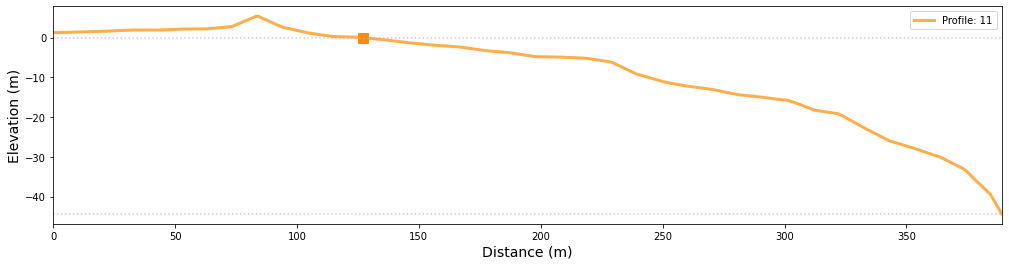

In [6]:
Plot_profile(profile)

### Load waves

In [7]:
# Simulation
sim=Load_SIM_NEARSHORE_all(db_S6,vns=['Hs','Tp','Dir'], decode_times=False, use_cftime=False, prf=prf)
print(sim)
sim2=db_S6.Load_SIM_OFFSHORE_all(vns=['level','wind_dir','wind_speed'], decode_times=False, use_cftime=False) #Level=SS+AT+MMSL
sim['level']=sim2.level
sim['wind_dir']=sim2.wind_dir
sim['wind_speed']=sim2.wind_speed
print(sim)

<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765833)
Coordinates:
  * time     (time) int64 262968 262969 262970 ... 9028798 9028799 9028800
  * n_sim    (n_sim) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Hs       (time, n_sim) float64 3.049 0.8057 1.252 1.694 ... 1.94 1.679 1.497
    Tp       (time, n_sim) float64 7.478 6.651 6.785 ... -0.2845 10.48 6.859
    Dir      (time, n_sim) float64 296.1 316.2 11.76 328.5 ... 6.929 16.05 26.74
<xarray.Dataset>
Dimensions:     (n_sim: 10, time: 8765833)
Coordinates:
  * time        (time) int64 262968 262969 262970 ... 9028798 9028799 9028800
  * n_sim       (n_sim) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Hs          (time, n_sim) float64 3.049 0.8057 1.252 ... 1.94 1.679 1.497
    Tp          (time, n_sim) float64 7.478 6.651 6.785 ... -0.2845 10.48 6.859
    Dir         (time, n_sim) float64 296.1 316.2 11.76 ... 6.929 16.05 26.74
    level       (time, n_sim) float64 -0.1975 -0.1667 -0.1524 ... nan nan nan
    wind_dir    (time,

In [8]:
SIM=sim.to_dataframe().reset_index()
print(SIM)
SIM.to_pickle(os.path.join(db_S6.paths.site.SIMULATION.nearshore,'Simulations_profile_'+str(prf)))

          n_sim     time        Hs        Tp         Dir     level   wind_dir  \
0             0   262968  3.049326  7.477855  296.076355 -0.197515  69.916573   
1             0   262969  3.043524  7.477855  296.076355 -0.158739  69.916573   
2             0   262970  3.037722  7.477855  296.076355 -0.088466  69.916573   
3             0   262971  3.031919  7.477855  296.076355 -0.000945  69.916573   
4             0   262972  3.026117  7.477855  296.076355  0.081685  69.916573   
...         ...      ...       ...       ...         ...       ...        ...   
87658325      9  9028796  1.497305  7.883459   20.840714 -0.496338  86.757362   
87658326      9  9028797  1.497305  7.883459   20.840714 -0.326600  86.757362   
87658327      9  9028798  1.497305  7.883459   20.840714 -0.162790  86.757362   
87658328      9  9028799  1.497305  7.883459   20.840714 -0.040239  86.757362   
87658329      9  9028800  1.497305  6.858707   26.737032       NaN        NaN   

          wind_speed  
0   